In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from pathlib import Path
import warnings
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder, PowerTransformer
import os
warnings.filterwarnings("ignore")

%matplotlib inline

#### Data Load

In [4]:
data_df = pd.read_csv('/Users/hypernova/Public/Akash Stuff/Stream_Flix/StreamFlix_Churn_Analysis/data/raw/Customer-Churn.csv')

In [14]:
print(data_df.head(3).T)

                                 0             1               2
customerID              7590-VHVEG    5575-GNVDE      3668-QPYBK
gender                      Female          Male            Male
SeniorCitizen                    0             0               0
Partner                        Yes            No              No
Dependents                      No            No              No
tenure                           1            34               2
PhoneService                    No           Yes             Yes
MultipleLines     No phone service            No              No
InternetService                DSL           DSL             DSL
OnlineSecurity                  No           Yes             Yes
OnlineBackup                   Yes            No             Yes
DeviceProtection                No           Yes              No
TechSupport                     No            No              No
StreamingTV                     No            No              No
StreamingMovies          

In [31]:
print(data_df.info())

<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   str    
 1   gender            7043 non-null   str    
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   str    
 4   Dependents        7043 non-null   str    
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   str    
 7   MultipleLines     7043 non-null   str    
 8   InternetService   7043 non-null   str    
 9   OnlineSecurity    7043 non-null   str    
 10  OnlineBackup      7043 non-null   str    
 11  DeviceProtection  7043 non-null   str    
 12  TechSupport       7043 non-null   str    
 13  StreamingTV       7043 non-null   str    
 14  StreamingMovies   7043 non-null   str    
 15  Contract          7043 non-null   str    
 16  PaperlessBilling  7043 non-null   str    
 17  Paymen

#### Insights 

* Found no null entries

* Total Charges is str column, but it should be float. Tried using pd.to_numeric, but found blank spaces in it. Found 7 such cases, and hence removing them from the data. 




In [34]:
len(data_df[data_df['TotalCharges']== ' '])

11

In [35]:
data_df = data_df[data_df['TotalCharges']!= ' ']

In [36]:
data_df['TotalCharges'] = pd.to_numeric(data_df['TotalCharges'])

#### Seggreating columns based on category and numerical

In [41]:
numerical_cols = [cols for cols in data_df.columns if data_df[cols].dtype == 'int' or data_df[cols].dtype == 'float']

In [57]:
categorical_cols = [cols for cols in data_df.columns if (data_df[cols].dtype != 'int' or data_df[cols].dtype != 'float') and cols != 'customerID']

In [58]:

continuous_cols = [cols for cols in data_df.columns if (len(data_df[cols].unique()) >=25) and (data_df[cols].dtype == 'int' or data_df[cols].dtype == 'float')]

In [62]:

discrete_cols = [cols for cols in data_df.columns if (len(data_df[cols].unique()) <25) and cols != 'customerID']

#### Check for duplicates

In [5]:
data_df.duplicated().sum()

np.int64(0)

#### Feature generations and transformation

In [64]:
data_df['Churn'] = data_df['Churn'].replace({'Yes':1,"No":0})


#### Check for Skewness

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

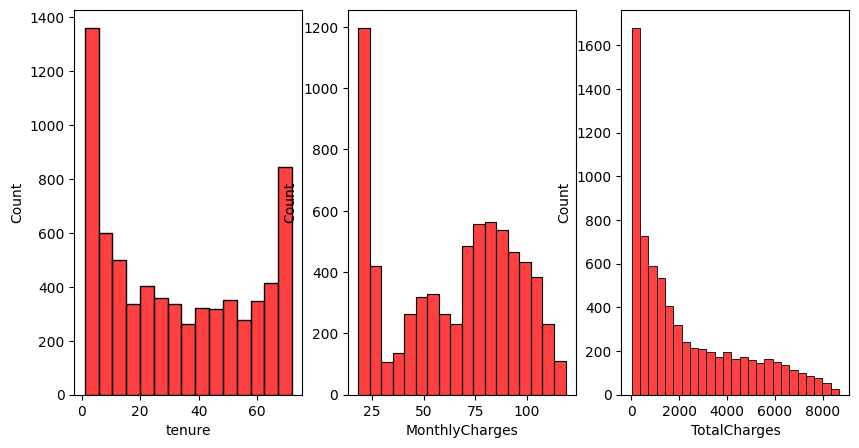

In [72]:
plt.figure(figsize = (10,5))

for i in range(0 , len(continuous_cols)):
    plt.subplot(1,3,i+1)
    sns.histplot(data = data_df, x = data_df[continuous_cols[i]], color='red')
    
plt.tight_layout


In [77]:
data_df[continuous_cols].skew(axis=0, skipna=True) 

tenure            0.237731
MonthlyCharges   -0.222103
TotalCharges      0.961642
dtype: float64

#### Insights

* Found not much skewness in the data, and hence moving ahead from this

#### Feature engineering

In [99]:
binary_class_var = [cols for cols in data_df.columns if cols in discrete_cols and len(data_df[cols].unique())==2]

In [100]:
binary_class_var

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [87]:

multi_class_var =  [cols for cols in data_df.columns if cols in discrete_cols and len(data_df[cols].unique())>2]

In [88]:
multi_class_var

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [101]:
for var in binary_class_var:
    data_df[var] = data_df[var].replace({data_df[var].unique()[0]:1,data_df[var].unique()[1]:0},inplace = True)

In [102]:
data_df.head(5).T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,1,0,0,0,1
SeniorCitizen,1,1,1,1,1
Partner,1,0,0,0,0
Dependents,1,1,1,1,1
tenure,1,34,2,45,2
PhoneService,1,0,0,1,0
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


#### Insights:

* Converted the binary variables in 1 and 0.

* In modelling step, we will add columns transformation in the pipeline

In [122]:
data_df.to_csv(f'{Path.cwd().parent}/data/processed/processed_data.csv')